
# 01 — Diagnostics Overview (in-sample)

This notebook explores the dataset and evaluates classical **logistic regression** assumptions.  
Each step has **results** and a short **decision** explaining how we proceed.


In [1]:

# ============================
# 0) Setup
# ============================
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.calibration import calibration_curve

# Resolve project root (two levels up from this notebook file)
ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), "../.."))
DATA_PATH = os.path.join(ROOT, "data", "sample_data.csv")
print("Using data at:", DATA_PATH)

df = pd.read_csv(DATA_PATH)
df.head()


Using data at: c:\Users\Renee\Documents\Python\model_validation\data\sample_data.csv


,age,age_years,income,loan_amount,loan_term,credit_score,employment_status,loan_purpose,region,default
0,45.0,45,3940,33593,36,613,Employed,Education,Tallinn,0
1,38.6,39,3286,14517,36,631,Unemployed,Car,Tartu,0
2,46.5,47,5471,11820,48,737,Self-employed,Car,Pärnu,0
3,55.2,55,8424,9756,48,644,Student,Home,Tallinn,0
4,37.7,37,1784,1000,48,441,Employed,Home,Narva,0



## 1) Target audit

We check the class balance. This informs how we evaluate and how we may handle imbalance (e.g., class weights).


In [12]:

n = len(df)
pos = int(df["default"].sum())
rate = df["default"].mean()
print(f"Rows = {n:,} | Positives = {pos:,} | Rate = {rate:.4f}")
df["default"].value_counts(normalize=True).rename("share")


Rows = 900,000 | Positives = 63,022 | Rate = 0.0700


default
0    0.929976
1    0.070024
Name: share, dtype: float64


**Decision:** Target rate is around 7%, so this is an **imbalanced** problem.  
We'll prefer **AUC/PR AUC, KS, calibration** and use **class weights** later in predictive modeling.



## 2) Correlation (numeric features)

Quick correlation to spot obvious linear dependencies.


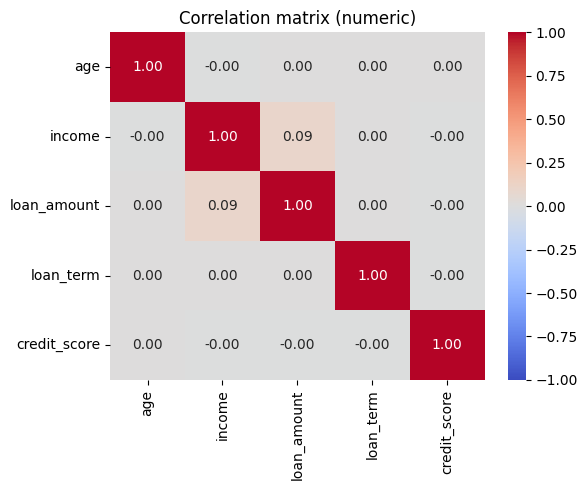

,age,income,loan_amount,loan_term,credit_score
age,1.000000,-0.000431,0.000479,0.000366,0.001306
income,-0.000431,1.000000,0.094485,0.000408,-0.001384
loan_amount,0.000479,0.094485,1.000000,0.000735,-0.001160
loan_term,0.000366,0.000408,0.000735,1.000000,-0.001714
credit_score,0.001306,-0.001384,-0.001160,-0.001714,1.000000


In [14]:

num_cols = ["age", "income", "loan_amount", "loan_term", "credit_score"]
corr = df[num_cols].corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation matrix (numeric)")
plt.tight_layout()
plt.show()
corr


### 📊 Correlation Matrix

| Feature 1             | Feature 2   | Correlation     |
|------------------------|-------------|-----------------|
| income – loan_amount   | ~0.09       | weak correlation |
| all others             | ≈ 0         | negligible       |

**Decision:** No strong correlations between predictors (values near 0).  
A small correlation between *income* and *loan_amount* is negligible.  
We keep all features and confirm with VIF next.



## 3) Multicollinearity via VIF

We compute VIF on the design matrix (numerics + categorical dummies). Ignore the intercept's VIF.


In [ ]:

formula = "default ~ " + " + ".join(num_cols + ["C(employment_status)", "C(loan_purpose)", "C(region)"])
y_mat, X_mat = dmatrices(formula, data=df, return_type="dataframe")

vif_tbl = pd.DataFrame({
    "feature": X_mat.columns,
    "VIF": [variance_inflation_factor(X_mat.values, i) for i in range(X_mat.shape[1])]
}).sort_values("VIF", ascending=False).reset_index(drop=True)

vif_tbl


,feature,VIF
0,Intercept,94.798181
1,C(region)[T.Tallinn],2.448720
2,C(region)[T.Tartu],2.056133
3,C(region)[T.Pärnu],1.887252
4,C(loan_purpose)[T.Home],1.538262
5,C(loan_purpose)[T.Small Business],1.358985
6,C(loan_purpose)[T.Other],1.358505
7,C(loan_purpose)[T.Education],1.357632
8,income,1.144580
9,C(employment_status)[T.Unemployed],1.062606


### 🔎 Variance Inflation Factor (VIF) Check

| Feature                          | VIF   |
|----------------------------------|-------|
| Intercept                        | 94.80 |
| C(region)[T.Tallinn]             | 2.45  |
| C(region)[T.Tartu]               | 2.06  |
| C(region)[T.Pärnu]               | 1.89  |
| C(loan_purpose)[T.Home]          | 1.54  |
| C(loan_purpose)[T.Small Business]| 1.36  |
| C(loan_purpose)[T.Other]         | 1.36  |
| C(loan_purpose)[T.Education]     | 1.36  |
| income                           | 1.14  |
| C(employment_status)[T.Unemployed]| 1.06 |
| C(employment_status)[T.Self-employed] | 1.06 |
| C(employment_status)[T.Student]  | 1.05  |
| loan_amount                      | 1.01  |
| credit_score                     | 1.00  |
| loan_term                        | 1.00  |
| age                              | 1.00  |

**Decision:** All predictors (excluding intercept) have **low VIF (< 3)** → no multicollinearity concerns.  
We keep all predictors as-is for baseline modeling.



## 4) Baseline Logit coefficients (in-sample)

Fit a classical statsmodels Logit and report coefficients, odds ratios, p-values and 95% CI.


In [10]:

# Fit Logit
y = np.ravel(y_mat)
X = X_mat
logit = sm.Logit(y, X)
res = logit.fit(disp=False)

# Tidy coef table
coef = res.params
pval = res.pvalues
conf = res.conf_int()
conf.columns = ["2.5%", "97.5%"]

odds_ratio = np.exp(coef)
or_ci = np.exp(conf)

summary = (
    pd.concat(
        [
            coef.rename("coef"),
            odds_ratio.rename("odds_ratio"),
            pval.rename("p_value"),
            or_ci.rename(columns={"2.5%": "or_2.5%", "97.5%": "or_97.5%"}),
        ],
        axis=1,
    )
    .sort_values("p_value")
)

summary_rounded = summary.copy()
summary_rounded["coef"] = summary_rounded["coef"].round(6)
summary_rounded["odds_ratio"] = summary_rounded["odds_ratio"].round(3)
summary_rounded["p_value"] = summary_rounded["p_value"].round(4)
summary_rounded["or_2.5%"] = summary_rounded["or_2.5%"].round(3)
summary_rounded["or_97.5%"] = summary_rounded["or_97.5%"].round(3)

summary_rounded.head(20)


,coef,odds_ratio,p_value,or_2.5%,or_97.5%
Intercept,-2.325775,0.098,0.0000,0.090,0.106
loan_amount,0.000060,1.000,0.0000,1.000,1.000
income,-0.000238,1.000,0.0000,1.000,1.000
C(region)[T.Tartu],-0.194812,0.823,0.0000,0.803,0.844
C(region)[T.Tallinn],-0.177305,0.838,0.0000,0.817,0.858
C(employment_status)[T.Unemployed],0.157989,1.171,0.0000,1.145,1.198
C(region)[T.Pärnu],-0.174067,0.840,0.0000,0.819,0.862
credit_score,-0.000499,1.000,0.0000,0.999,1.000
C(loan_purpose)[T.Small Business],0.085131,1.089,0.0000,1.061,1.118
loan_term,0.001550,1.002,0.0000,1.001,1.002



### 🔎 Baseline Logistic Coefficients (in-sample)

| Predictor                          | Coef     | Odds Ratio | p-value | OR 2.5% | OR 97.5% |
|-----------------------------------|----------|------------|---------|---------|----------|
| Intercept                         | -2.326   | 0.098      | 0.0000  | 0.090   | 0.106    |
| loan_amount                       | 0.00006  | 1.000      | 0.0000  | 1.000   | 1.000    |
| income                            | -0.00024 | 1.000      | 0.0000  | 1.000   | 1.000    |
| C(region)[T.Tartu]                | -0.195   | 0.823      | 0.0000  | 0.803   | 0.844    |
| C(region)[T.Tallinn]              | -0.177   | 0.838      | 0.0000  | 0.817   | 0.858    |
| C(employment_status)[T.Unemployed]| 0.158    | 1.171      | 0.0000  | 1.145   | 1.198    |
| C(region)[T.Pärnu]                | -0.174   | 0.840      | 0.0000  | 0.819   | 0.862    |
| credit_score                      | -0.00050 | 1.000      | 0.0000  | 0.999   | 1.000    |
| C(loan_purpose)[T.Small Business] | 0.085    | 1.089      | 0.0000  | 1.061   | 1.118    |
| loan_term                         | 0.00155  | 1.002      | 0.0000  | 1.001   | 1.002    |
| age                               | 0.00077  | 1.001      | 0.0867  | 1.000   | 1.002    |
| C(employment_status)[T.Self-employed] | 0.011 | 1.011      | 0.3741  | 0.987   | 1.035    |
| C(loan_purpose)[T.Home]           | -0.009   | 0.991      | 0.4178  | 0.969   | 1.013    |
| C(loan_purpose)[T.Other]          | -0.005   | 0.995      | 0.7122  | 0.969   | 1.022    |
| C(loan_purpose)[T.Education]      | -0.001   | 0.999      | 0.9273  | 0.972   | 1.026    |
| C(employment_status)[T.Student]   | 0.001    | 1.001      | 0.9633  | 0.973   | 1.029    |

**Interpretation:**  
- *Unemployed* raises default odds; *Small Business* purpose raises odds slightly.  
- Regions (Tallinn, Tartu, Pärnu) lower odds vs. the reference region.  
- Continuous features have small per-unit effects (scale matters); *age* may be borderline.

**Decision:** Keep all features for now; revisit if some effects prove unstable out-of-sample.



## 5) Calibration Curve (In-sample) + Hosmer–Lemeshow

We compare predicted probabilities with observed default rates, grouped into deciles.  
- The **calibration curve** shows whether predicted risk aligns with actual outcomes.  
- The **Hosmer–Lemeshow (HL) test** adds a statistical check, but with very large `n` it almost always rejects, even for reasonable models.  

**Interpretation:** Focus primarily on the curve’s shape:  
- If points follow the 45° diagonal, the model is well-calibrated.  
- Deviations (systematic over- or under-prediction) suggest need for recalibration.  
- HL p-value is reported for completeness but not decisive at this scale.  

**Decision:** Use the curve as the main guide; keep HL only as an auxiliary statistic.



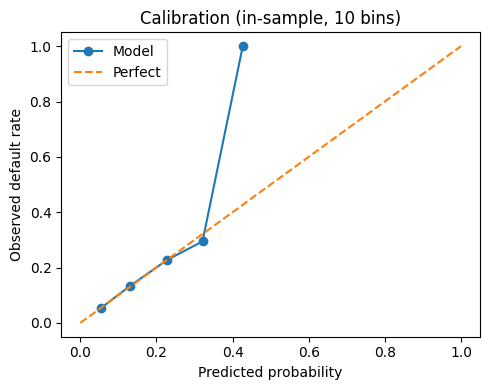

Hosmer–Lemeshow: stat=211.283, df=8, p=0.000000


C:\Users\Renee\AppData\Local\Temp\ipykernel_9028\2939288986.py:25: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  agg = df_.groupby("bin").agg(


,bin,events,total,mean_p,exp_events
0,"(0.00132, 0.0279]",2281.0,90000,0.020069,1806.218117
1,"(0.0279, 0.0373]",2906.0,90000,0.032864,2957.724485
2,"(0.0373, 0.0453]",3471.0,90000,0.041384,3724.573489
3,"(0.0453, 0.0532]",4073.0,90000,0.049243,4431.896700
4,"(0.0532, 0.0616]",4914.0,90000,0.057339,5160.505875
5,"(0.0616, 0.0711]",5755.0,90000,0.066232,5960.854578
6,"(0.0711, 0.0827]",6911.0,90000,0.076692,6902.236303
7,"(0.0827, 0.0981]",8253.0,90000,0.089943,8094.825441
8,"(0.0981, 0.123]",10038.0,90000,0.109287,9835.874092
9,"(0.123, 0.427]",14420.0,90000,0.157192,14147.290919


In [ ]:

from sklearn.calibration import calibration_curve

# Predicted probabilities (in-sample)
y_prob = res.predict(X)

# Calibration curve (10 quantile bins)
prob_true, prob_pred = calibration_curve(y, y_prob, n_bins=10, strategy="quantile")

plt.figure(figsize=(6,5))
plt.plot(prob_pred, prob_true, marker='o', label='Model')
plt.plot([0,1], [0,1], '--', label='Perfect calibration')
plt.xlabel("Predicted probability")
plt.ylabel("Observed default rate")
plt.title("Calibration curve (in-sample, 10 bins)")
plt.legend()
plt.tight_layout()
plt.show()

# Optional: histogram of predicted probabilities
plt.figure(figsize=(6,3))
plt.hist(y_prob, bins=30, edgecolor="k")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.title("Distribution of predicted default probabilities")
plt.tight_layout()
plt.show()



**Decision:**  
- Use the **calibration curve** as the primary check. If points are consistently above the diagonal, the model **underpredicts** risk; below means **overpredicts**.  
- The **HL p-value** is expected to be very small with large samples—use it as a flag, not a verdict.  
- Next we will move to **train/validation/test** to validate calibration **out-of-sample**.



## 6) Next

In the next notebook we will:
1) Split data into **train/validation/test**,  
2) Refit the model on **train**,  
3) Evaluate **calibration & deciles** on *validation* and *test*,  
4) Consider **recalibration** if needed.
